In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import geopandas as gpd
import rioxarray as rxr
import rasterio
from rasterio.plot import show, adjust_band
from matplotlib import cm
import matplotlib
from scipy import stats
import datetime
from constants import *
import pickle
os.chdir(home_dir)
plt.style.use(home_dir+'stylefile.mplstyle')

tmp = []
for i in range(len(fire_sn)):
    tmp.append(datetime.datetime.strptime(fire_sn['Ig_Date'][i], '%Y-%m-%d'))
fire_sn['dt'] = tmp

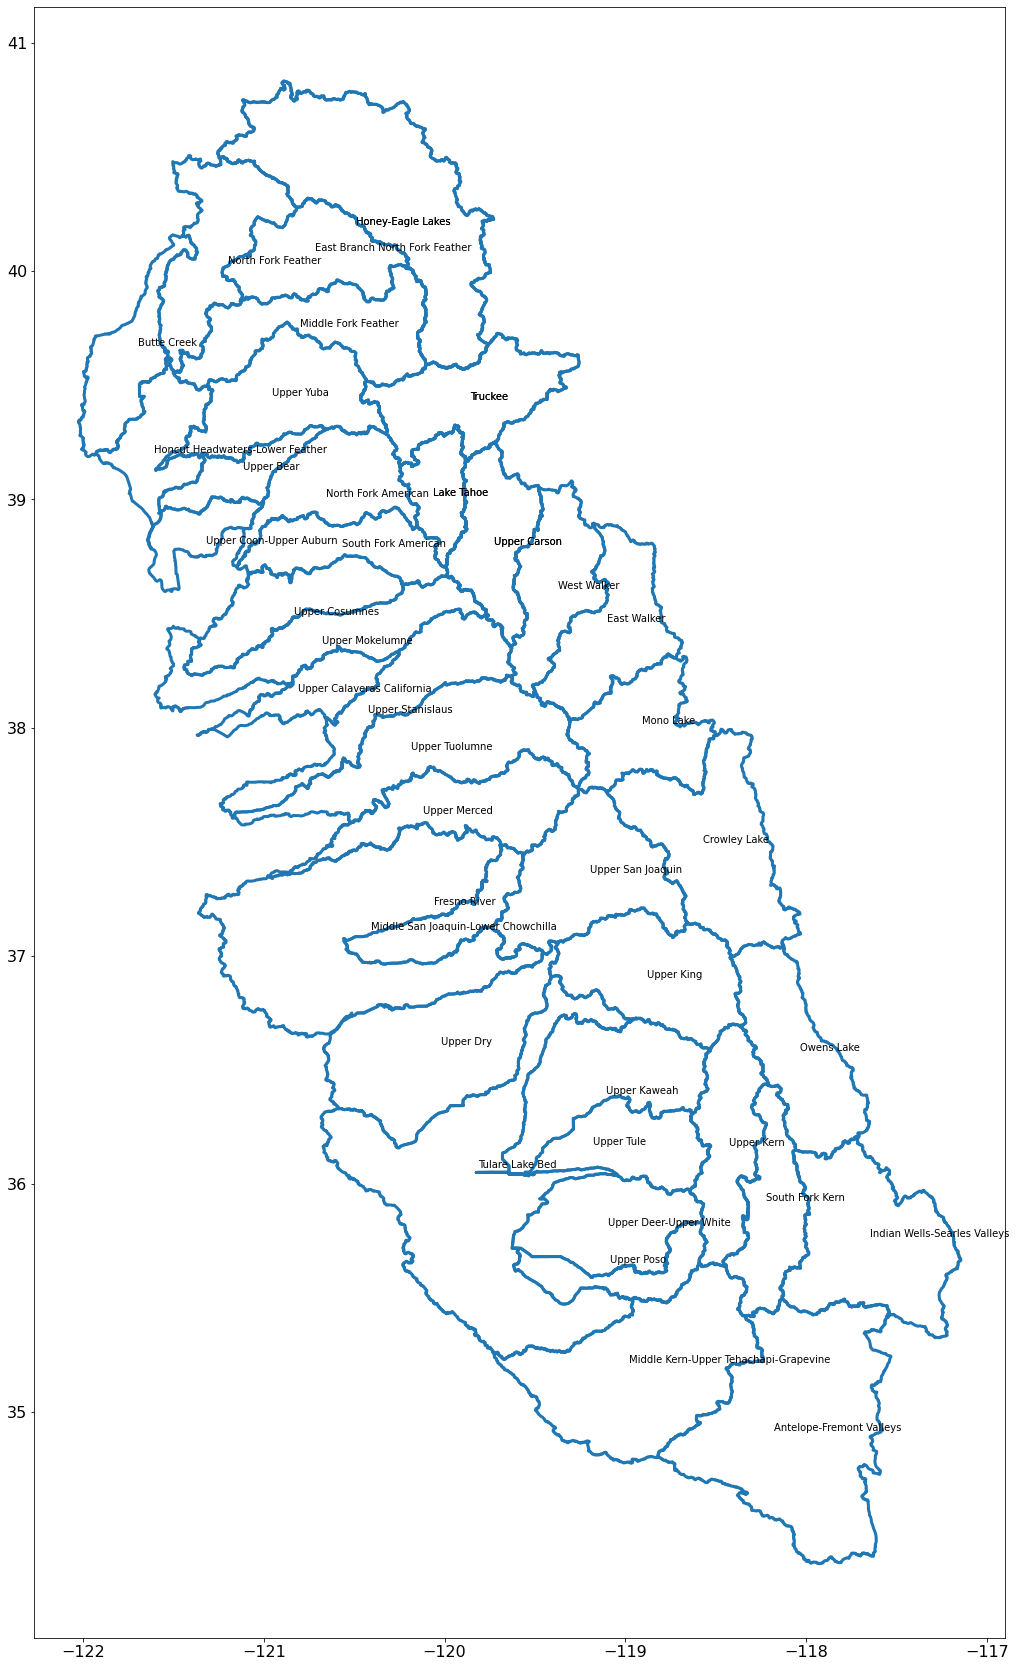

In [3]:
f,ax=plt.subplots(figsize=(30,30))
sn_watersheds.boundary.plot(ax=ax)
for i in sn_watersheds.index:
    tmp = sn_watersheds[(sn_watersheds.index==i)]
    x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
    y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
    name = tmp.name[i]
    ax.text(x,y,name)

In [5]:
# san joaquin watershed
targets = ['Upper San Joaquin'] #,'Upper Tuolumne']
names = sn_watersheds.name
tmp =[names[i] in targets for i in range(len(names))]
idx = np.arange(44)[tmp]
tmp1 = sn_watersheds[sn_watersheds.index == 1]
tmp2 = sn_watersheds[sn_watersheds.index == 2]
tmp3 = tmp1.append(tmp2)
tmp3

# san joaquin watershed
targets = ['Upper San Joaquin','Upper Tuolumne','Upper King','Upper Merced','Upper Kaweah','Upper Kern','Upper Tule']
sj = sn_watersheds[sn_watersheds.name == targets[0]]
for t in range(1,len(targets)):
    tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
    sj = sj.append(tmp)
sj.name
sj.to_file('upper_watersheds.shp')


In [6]:
targets_sw = ['Upper San Joaquin','Upper Tuolumne','Upper King','Upper Merced','Upper Kaweah','Upper Kern','Upper Tule','South Fork Kern']
targets_se = ['West Walker','East Walker','Mono Lake','Crowley Lake','Owens Lake','Indian Wells-Searles Valley']
targets_ne = ['East Branch North Fork Feather','Middle Fork Feather','Truckee','Lake Tahoe','Upper Carson']
targets_nw = ['Upper Yuba','North Fork American','South Fork American','Upper Cosumnes','Upper Mokelumne','Upper Stanislaus']
targets_all = [targets_sw,targets_se,targets_ne,targets_nw]

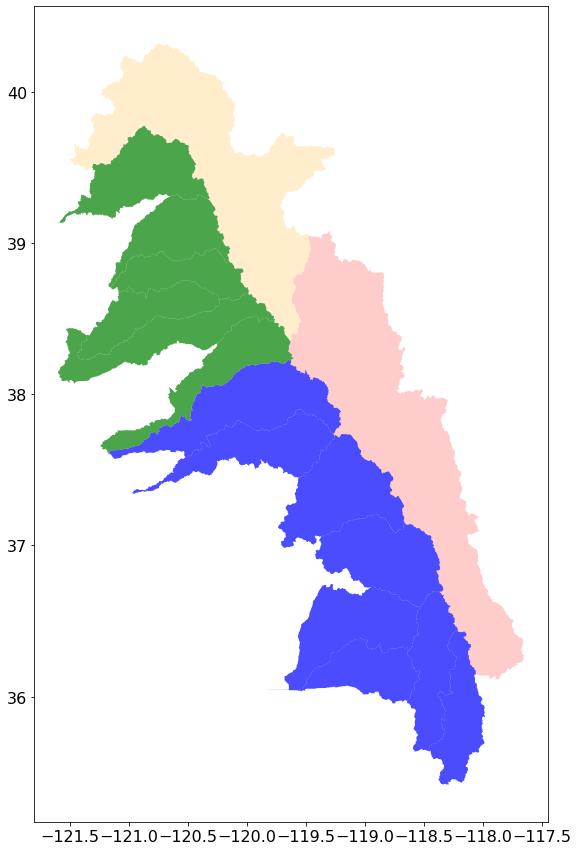

'\nfor i in sn_watersheds.index:\n    tmp = sn_watersheds[(sn_watersheds.index==i)]\n    x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2\n    y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2\n    name = tmp.name[i]\n    ax.text(x,y,name)\n'

<Figure size 432x288 with 0 Axes>

In [7]:
## make subplots for different regions
f,ax=plt.subplots(1,1, figsize=(10,15))
f.patch.set_alpha(0)
ax.patch.set_alpha(0)
ax.patch.set_facecolor('white')
#axs=ax.flatten()
# sn_watersheds.boundary.plot(ax=ax)
colors = ['blue','red','orange','green']

for i,targets in enumerate(targets_all):
    sheds = sn_watersheds[sn_watersheds.name == targets[0]]
    for t in range(1,len(targets)):
        tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
        try:
            tmp = tmp[tmp.index==tmp.index[0]]
        except:
            continue
        #print(len(tmp))
        #x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
        # y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
        #name = tmp.name[i]
        #ax.text(x,y,name)
        sheds = sheds.append(tmp)
    if(targets==targets_sw): sheds.plot(ax=ax, color = colors[i],alpha = 0.7)
    if(targets==targets_nw): sheds.plot(ax=ax, color = colors[i],alpha = 0.7)
    if(targets==targets_ne): sheds.plot(ax=ax, color = colors[i],alpha = 0.2)
    if(targets==targets_se): sheds.plot(ax=ax, color = colors[i],alpha = 0.2)

    #for k in range(4): sheds.plot(ax=axs[k], color = colors[i],alpha = 0.2)
        
plt.show()
plt.savefig('regions.png')
'''
for i in sn_watersheds.index:
    tmp = sn_watersheds[(sn_watersheds.index==i)]
    x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
    y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
    name = tmp.name[i]
    ax.text(x,y,name)
'''

In [19]:
import contextily as cx

Text(0.5, 135.35999999999993, ' ')

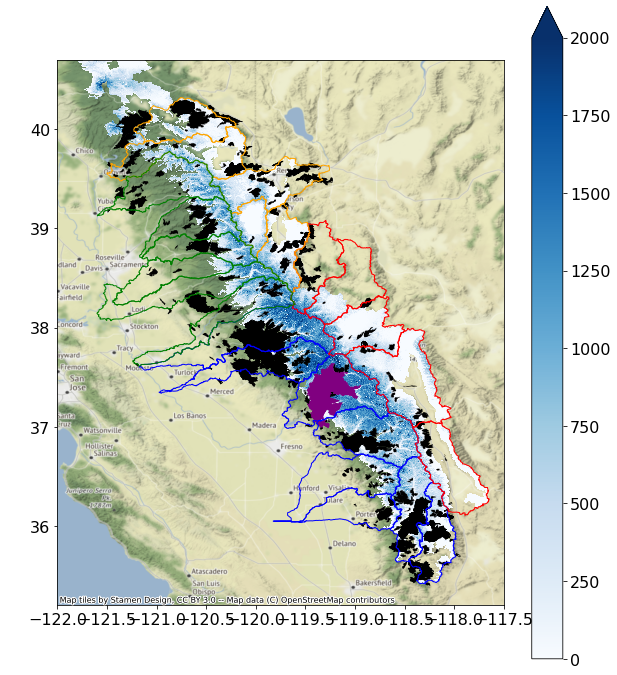

In [23]:
## make subplots for different regions
f,ax=plt.subplots(1,1, figsize=(10,12))
#axs=ax.flatten()
# sn_watersheds.boundary.plot(ax=ax)
colors = ['blue','red','orange','green']
fires = gpd.read_file(data_dir+'firebounds_sn.gdf')
creek = gpd.read_file(home_dir + 'creek.shp')
swe = rxr.open_rasterio(data_dir + 'max_swe/max_swe'+str(2005)+'.tif')
swe = swe.rio.write_crs(sn_watersheds.crs)
swe.plot(ax=ax,cmap = 'Blues',vmin=0,vmax=2000)
for i,targets in enumerate(targets_all):
    sheds = sn_watersheds[sn_watersheds.name == targets[0]]
    for t in range(1,len(targets)):
        tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
        try:
            tmp = tmp[tmp.index==tmp.index[0]]
        except:
            continue
        #print(len(tmp))
        #x = (tmp.bounds.minx[i]+tmp.bounds.maxx[i])/2
        # y = (tmp.bounds.miny[i]+tmp.bounds.maxy[i])/2
        #name = tmp.name[i]
        #ax.text(x,y,name)
        sheds = sheds.append(tmp)
        # sheds = sheds.to_crs(epsg=3857)
    #sheds.plot(ax=axs[i], color = colors[i],alpha = 0.7)

    sheds.boundary.plot(ax=ax, color = colors[i],alpha = 1,linewidth=1)
    fires = fires.to_crs(sheds.crs)
    fires_in = gpd.sjoin(fires,sheds)
    fires_in.geometry.plot(ax=ax,alpha=1,color='k',label ='fire boundaries')
    #fires_in.boundary.plot(ax=ax,color='k',linewidth=0.3)
creek.plot(ax=ax,color='purple',alpha=1,linewidth =2)
ax.set_xbound([-122,-117.5])
ax.set_ybound([35.2,40.7])
cx.add_basemap(ax,crs = sheds.crs,source=cx.providers.Stamen.Terrain)
#ax.legend()
ax.set_title(' ')
ax.set_ylabel(' ')  
ax.set_xlabel(' ')
#plt.show()
#plt.savefig('regions_fires')


In [43]:
def watershed_data_burned(targets,filename, gpp_opt = 'MODIS'):
    sj = sn_watersheds[sn_watersheds.name == targets[0]]
    month_ids = ['00','01','02','03','04','05','06','07','08','09','10','11','12']

    for t in range(1,len(targets)):
        tmp = sn_watersheds[(sn_watersheds.name==targets[t])]
        sj = sj.append(tmp)
    
    import datetime

    fire_time = 10 #yrs
    swe_sj = {}
    swe_sj_burned = {}
    swe_sj_unburned = {}
    sai_sj = {}
    sai_sj_burned = {}
    sai_sj_unburned = {}

    gpp_sj = {}
    gpp_tot_sj ={}
    gpp_sj_burned = {}
    gpp_sj_unburned = {}
    gpp_tot_sj_burned ={}
    gpp_tot_sj_unburned ={}
    ndvi_sj = {}
    ndvi_sj_burned = {}
    ndvi_sj_unburned = {}
    for yr in range(2000,2016):
        timestop =datetime.datetime(yr,10,1)
        timestart = datetime.datetime(yr-fire_time,10,1)
        prev_fires = fire_sn[fire_sn['dt']<timestop]
        prev_fires = prev_fires[prev_fires['dt']>timestart]

        swe = rxr.open_rasterio(data_dir + 'max_swe/max_swe'+str(yr)+'.tif')
        swe = swe.rio.write_crs(sj.crs)
        clipped = swe.rio.clip(sj.geometry,all_touched=True,from_disk=False)
        clipped.rio.set_nodata(np.nan)
        swe_sj[yr]=clipped
        out_fire = clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        swe_sj_unburned[yr]=out_fire
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
        swe_sj_burned[yr]=in_fire

        #SAI
        sai = rxr.open_rasterio(pe_data_dir + 'sai_'+str(yr)+'.tif')
        clipped = sai.rio.clip(sj.geometry,all_touched=True)
        clipped.rio.set_nodata(np.nan)
        clipped[np.where(clipped==np.inf)]=np.nan
        clipped[np.where(clipped>3000)]=np.nan
        clipped[np.where(clipped<0)]=np.nan
        sai_sj[yr]=clipped
        out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        sai_sj_unburned[yr] = out_fire
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False)
        sai_sj_burned[yr]=in_fire
        # GPP
        id = yr-2000
        gpp_means = []
        gpp_means_burned = []
        gpp_means_unburned = []
        gpp_all = {}
        gpp_all_burned = {}
        gpp_all_unburned = {}
        for mo in range(1,13):
            gppmean = 0
            gppmean_burned = 0
            try:
                if (gpp_opt =='MODIS'):
                    fn = data_dir + '/modis_clip/modis_clip_'+str(id)+'_'+str(mo)+'.tif'
                    # print('gpp from modis')
                    cutoff = 5000
                elif(gpp_opt =='GOSIF'):
                    fn = 'c:/users/marianne/documents/data/GOSIF/data.globalecology.unh.edu/data/GOSIF-GPP_v2/Monthly/Mean/GOSIF_GPP_'+str(yr)+'.M' + month_ids[mo]+'_Mean.tif'
                    # print('gpp from gosif')
                    cutoff = 50000
                tmp = rxr.open_rasterio(fn)
                clipped = tmp.rio.clip(sj.geometry,all_touched=True)
                clipped[np.where(clipped>cutoff)] = np.nan
                gppmean = np.nanmean(clipped)
                print(gppmean)
                gpp_all[mo]=clipped
                out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
                in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False)
                gpp_all_burned[mo]=in_fire
                gpp_all_unburned[mo]=out_fire
                gppmean_burned = np.nanmean(in_fire)
                gppmean_unburned = np.nanmean(out_fire)
            except:
                continue
            gpp_means.append(gppmean)
            gpp_means_burned.append(gppmean_burned)
            gpp_means_unburned.append(gppmean_unburned)
        max_mo = np.nanargmax(gpp_means)+1
        if (gpp_opt == 'GPP'):
            fn = data_dir+'modis_clip/modis_clip_'+str(id)+'_'+str(max_mo)+'.tif'
            cutpff = 5000
        elif (gpp_opt == 'GOSIF'):
            fn = pe_data_dir + 'c:/users/marianne/documents/data/GOSIF/data.globalecology.unh.edu/data/GOSIF-GPP_v2/Monthly/Mean/GOSIF_GPP_'+str(yr)+'.M' + month_ids[max_mo]+'_Mean.tif'
            cutoff = 50000
        gpp = rxr.open_rasterio(data_dir+'modis_clip/modis_clip_'+str(id)+'_'+str(max_mo)+'.tif')
        clipped = gpp.rio.clip(sj.geometry,all_touched=True)
        clipped.rio.set_nodata(np.nan)
        clipped[np.where(clipped>cutoff)] = np.nan
        gpp_sj[yr]=clipped
        out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False)
        gpp_sj_burned[yr]=in_fire
        gpp_sj_unburned[yr]=out_fire
        gpp_sum = np.zeros((clipped.shape[1:]))
        for k in gpp_all.keys():
            gpp_sum += gpp_all[k][0,:,:]
        gpp_tot_sj[yr]=gpp_sum
        gpp_sum_burned = np.zeros((in_fire.shape[1:]))
        gpp_sum_unburned = np.zeros((out_fire.shape[1:]))
        for k in gpp_all_burned.keys():
            gpp_sum_burned += gpp_all_burned[k][0,:,:]
        gpp_tot_sj_burned[yr]=gpp_sum_burned
        for k in gpp_all_unburned.keys():
            gpp_sum_unburned += gpp_all_unburned[k][0,:,:]
        gpp_tot_sj_unburned[yr]=gpp_sum_unburned


        #NDVI
        ndvi = rxr.open_rasterio(data_dir + 'pe_snow_fires_data/max-ndvi/max-ndvi-' + str(yr)+'.tif')
        #pe = pe.rio.write_crs(sj.crs)
        clipped = ndvi.rio.clip(sj.geometry,all_touched=True)
        clipped.rio.set_nodata(np.nan)
        out_fire= clipped.rio.clip(prev_fires.geometry, from_disk=False, invert = True)
        in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk=False, invert = False)
        ndvi_sj[yr]=clipped
        ndvi_sj_burned[yr]=in_fire
        ndvi_sj_unburned[yr] = out_fire
    
    gpp_by_month = np.zeros((clipped.shape[1:]))
    gpp_by_month_burned = np.zeros((clipped.shape[1:]))
    gpp_by_month_unburned = np.zeros((clipped.shape[1:]))

    for yr in range(2000,2016):
        for mo in range(1,13):
                gppmean = 0
                gppmean_burned = 0
                try:
                    if (gpp_opt =='MODIS'):
                        fn = data_dir + 'modis_clip/modis_clip_'+str(yr-2000)+'_'+str(mo)+'.tif'
                    elif(gpp_opt == 'GOSIF'):
                        fn = 'c:/users/marianne/documents/data/GOSIF/data.globalecology.unh.edu/data/GOSIF-GPP_v2/Monthly/Mean/GOSIF_GPP_'+str(yr)+'.M' + month_ids[mo]+'_Mean.tif'
                    tmp = rxr.open_rasterio(fn)
                    clipped = tmp.rio.clip(sj.geometry,all_touched=True)
                    clipped[np.where(clipped>cutoff)] = np.nan
                    gppmean = np.nanmean(clipped)
                    gpp_by_month[yr-2000, mo-1] = gppmean
                    in_fire = clipped.rio.clip(prev_fires.geometry, all_touched= True, from_disk = True)
                    gpp_all_burned[mo]=in_fire
                    gppmean_burned = np.nanmean(in_fire)
                    gpp_by_month_burned[yr-2000, mo-1] = gppmean_burned
                    out_fire = clipped.rio.clip(prev_fires.geometry, all_touched= False, from_disk = True,invert=True)
                    gppmean_unburned = np.nanmean(out_fire)
                    gpp_by_month_unburned[yr-2000, mo-1] = gppmean_unburned
                except:
                    continue
    
    keys = range(2000,2015)
    swe_means = [np.nanmean(swe_sj[k]) for k in keys]
    sai_means = [np.nanmean(sai_sj[k]) for k in keys]
    gpp_means = [np.nanmean(gpp_sj[k+1]) for k in keys]
    ndvi_means = [np.nanmean(ndvi_sj[k+1]) for k in keys]
    gpp_tot_means = [np.nanmean(gpp_tot_sj[k+1]) for k in keys]
    swe_means_burned = [np.nanmean(swe_sj_burned[k]) for k in keys]
    sai_means_burned = [np.nanmean(sai_sj_burned[k]) for k in keys]
    gpp_means_burned = [np.nanmean(gpp_sj_burned[k+1]) for k in keys]
    ndvi_means_burned = [np.nanmean(ndvi_sj_burned[k+1]) for k in keys]
    gpp_tot_means_burned = [np.nanmean(gpp_tot_sj_burned[k+1]) for k in keys]
    swe_means_unburned = [np.nanmean(swe_sj_unburned[k]) for k in keys]
    sai_means_unburned = [np.nanmean(sai_sj_unburned[k]) for k in keys]
    gpp_means_unburned = [np.nanmean(gpp_sj_unburned[k+1]) for k in keys]
    ndvi_means_unburned = [np.nanmean(ndvi_sj_unburned[k+1]) for k in keys]
    gpp_tot_means_unburned = [np.nanmean(gpp_tot_sj_unburned[k+1]) for k in keys]

    swe_dev = [np.nanstd(swe_sj[k]) for k in keys]
    sai_dev = [np.nanstd(sai_sj[k]) for k in keys]
    gpp_dev = [np.nanstd(gpp_sj[k+1]) for k in keys]
    ndvi_dev = [np.nanstd(ndvi_sj[k+1]) for k in keys]
    gpp_tot_dev = [np.nanstd(gpp_tot_sj[k+1]) for k in keys]
    swe_dev_burned = [np.nanstd(swe_sj_burned[k]) for k in keys]
    sai_dev_burned = [np.nanstd(sai_sj_burned[k]) for k in keys]
    gpp_dev_burned = [np.nanstd(gpp_sj_burned[k+1]) for k in keys]
    ndvi_dev_burned = [np.nanstd(ndvi_sj_burned[k+1]) for k in keys]
    gpp_tot_dev_burned = [np.nanstd(gpp_tot_sj_burned[k+1]) for k in keys]
    swe_dev_unburned = [np.nanstd(swe_sj_unburned[k]) for k in keys]
    sai_dev_unburned = [np.nanstd(sai_sj_unburned[k]) for k in keys]
    gpp_dev_unburned = [np.nanstd(gpp_sj_unburned[k+1]) for k in keys]
    ndvi_dev_unburned = [np.nanstd(ndvi_sj_unburned[k+1]) for k in keys]
    gpp_tot_dev_unburned = [np.nanstd(gpp_tot_sj_unburned[k+1]) for k in keys]

    to_save = {'targets':targets,
                'swe_means': swe_means,
                'sai_means':sai_means,
                'gpp_means':gpp_means,
                'ndvi_means':ndvi_means,
                'gpp_tot_means':gpp_tot_means,
                'swe_means_burned': swe_means_burned,
                'sai_means_burned':sai_means_burned,
                'gpp_means_burned':gpp_means_burned,
                'ndvi_means_burned':ndvi_means_burned,
                'gpp_tot_means_burned':gpp_tot_means_burned,
                'swe_means_unburned': swe_means_unburned,
                'sai_means_unburned':sai_means_unburned,
                'gpp_means_unburned':gpp_means_unburned,
                'ndvi_means_unburned':ndvi_means_unburned,
                'gpp_tot_means_unburned':gpp_tot_means_unburned,
                'gpp_by_month_burned':gpp_by_month_burned,
                'gpp_by_month_unburned':gpp_by_month_unburned,
                'gpp_by_month':gpp_by_month,
                'swe_dev': swe_dev,
                'sai_dev':sai_dev,
                'gpp_dev':gpp_dev,
                'ndvi_dev':ndvi_dev,
                'gpp_tot_dev':gpp_tot_dev,
                'swe_dev_burned': swe_dev_burned,
                'sai_dev_burned':sai_dev_burned,
                'gpp_dev_burned':gpp_dev_burned,
                'ndvi_dev_burned':ndvi_dev_burned,
                'gpp_tot_dev_burned':gpp_tot_dev_burned,
                'swe_dev_unburned': swe_dev_unburned,
                'sai_dev_unburned':sai_dev_unburned,
                'gpp_dev_unburned':gpp_dev_unburned,
                'ndvi_dev_unburned':ndvi_dev_unburned,
                'gpp_tot_dev_unburned':gpp_tot_dev_unburned
                }
    
    with open(pe_data_dir + filename + '.pkl', 'wb') as file:
        pickle.dump(to_save, file)

    del clipped
    gc.collect()

    return targets

def plot_linear_four(xvar,yvar,gpp_opt='MODIS',normal = True):
    f,ax=plt.subplots(2,2,figsize=(15,10))
    axs = ax.flatten()
    colors = ['green','yellow','blue','red']
    col_b = 'darkgoldenrod'
    col_u ='seagreen'
    for k,region in enumerate(['northwest','northeast','southwest','southeast']):
    # for k,region in enumerate(['southwest']):
        with open(pe_data_dir + region + '_'+ gpp_opt + '.pkl', 'rb') as file:
            data = pickle.load(file)

        if normal:
            x_b = normalize(data[xvar+'_means_burned'])
            y_b = normalize(data[yvar+'_means_burned'])
            x_u = normalize(data[xvar+'_means_unburned'])
            y_u = normalize(data[yvar+'_means_unburned'])
            y_b_err = normalize(data[yvar+'_dev_burned'])
            x_b_err = normalize(data[xvar+'_dev_burned'])
            y_u_err = normalize(data[yvar+'_dev_unburned'])
            x_u_err = normalize(data[xvar+'_dev_unburned'])
        else:
            x_b = data[xvar+'_means_burned']
            y_b = data[yvar+'_means_burned']
            x_u = data[xvar+'_means_unburned']
            y_u = data[yvar+'_means_unburned']
            y_b_err = data[yvar+'_dev_burned']
            x_b_err = data[xvar+'_dev_burned']
            y_u_err = data[yvar+'_dev_unburned']
            x_u_err = data[xvar+'_dev_unburned']

        n = 1  # degree of polynomial
        
        p_b, C_p_b = np.polyfit(x_b, y_b, n, cov=True)  # C_p is estimated covariance matrix
        t_b = np.linspace(min(x_b), max(x_b), 500)
        TT_b = np.vstack([t_b**(n-i) for i in range(n+1)]).T
        yi_b = np.dot(TT_b, p_b)  # matrix multiplication calculates the polynomial values
        C_yi_b = np.dot(TT_b, np.dot(C_p_b, TT_b.T)) # C_y = TT*C_z*TT.T
        sig_yi_b = np.sqrt(np.diag(C_yi_b))  # Standard deviations are sqrt of diagonal

        p_u, C_p_u = np.polyfit(x_u, y_u, n, cov=True)  # C_p is estimated covariance matrix
        t_u = np.linspace(min(x_u), max(x_u), 500)
        TT_u = np.vstack([t_u**(n-i) for i in range(n+1)]).T
        yi_u = np.dot(TT_u, p_u)  # matrix multiplication calculates the polynomial values
        C_yi_u = np.dot(TT_u, np.dot(C_p_u, TT_u.T)) # C_y = TT*C_z*TT.T
        sig_yi_u = np.sqrt(np.diag(C_yi_u))  # Standard deviations are sqrt of diagonal

        
        axs[k].plot(x_b,y_b,'o',color=col_b,label='burned')
        axs[k].errorbar(x_b,y_b,yerr = y_b_err,xerr=x_b_err,fmt = 'o',color=col_b,label='burned')
        axs[k].fill_between(t_b, yi_b+sig_yi_b, yi_b-sig_yi_b, alpha=.25,color=col_b)
        axs[k].plot(t_b, yi_b,'-',color=col_b)


        axs[k].plot(x_u,y_u,'o',color=col_u,label='unburned')
        axs[k].errorbar(x_u,y_u,yerr = y_u_err,xerr=x_u_err,fmt = 'o',color=col_u,label='unburned')

        axs[k].fill_between(t_u, yi_u+sig_yi_u, yi_u-sig_yi_u, alpha=.25,color=col_u)
        axs[k].plot(t_u, yi_u,'-',color=col_u)

        axs[k].patch.set_alpha(0.2)

        axs[k].patch.set_facecolor(colors[k]) #,alpha=0.5)
        

        slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_b, y_b)
        slope_u, intercept_u, r_value_u, p_value_u, std_err_u = stats.linregress(x_u, y_u)

        if(k>1): axs[k].set_xlabel(xvar.upper())
        if(k%2==0):axs[k].set_ylabel(yvar.upper())
        # axs[k].set_title(region)
    #ax.legend()
    plt.show()



In [9]:
with open(pe_data_dir + 'southwest' + '_'+ 'gosif' + '.pkl', 'rb') as file:
            data = pickle.load(file)

In [10]:
fn = data_dir + 'modis_clip/modis_clip_'+str(10)+'_'+str(10)+'.tif'
tmp = rxr.open_rasterio(fn)
clipped = tmp.rio.clip(sn_watersheds.geometry,all_touched=True)
clipped[np.where(clipped>5000)] = np.nan
clipped[np.where(clipped==0)] = np.nan

swe = rxr.open_rasterio(data_dir + 'max_swe/max_swe'+str(2010)+'.tif')
swe = swe.rio.write_crs(sj.crs)
swe_clipped = swe.rio.clip(sn_watersheds.geometry,all_touched=True,from_disk=False)
swe_clipped = swe_clipped.rio.set_nodata(np.nan)
swe2 = rxr.open_rasterio('max_swe_rp.tif')
fig,ax = plt.subplots()
ax.plot(clipped.values.flatten(),'o')
fig,ax = plt.subplots()
ax.plot(swe2.values.flatten(),'o')

MemoryError: Unable to allocate 1.24 TiB for an array with shape (8792, 8792, 8792) and data type int16

In [11]:
len(swe2.values.flatten()),len(clipped.values.flatten())

NameError: name 'swe2' is not defined

In [66]:
len(swe2.values.flatten()),len(clipped.values.flatten())

(15048, 3180)

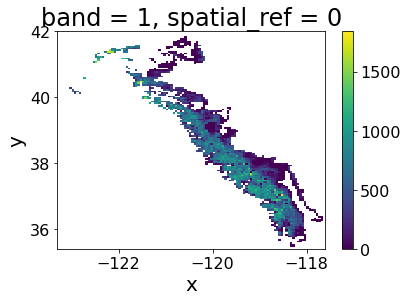

In [69]:
swe2.plot()

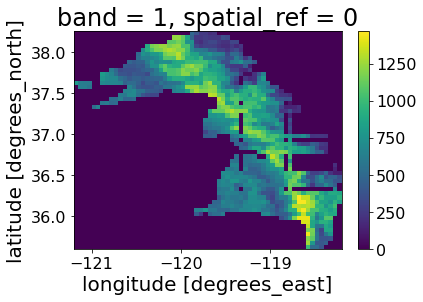

In [70]:
clipped.plot()

In [12]:
from osgeo import gdal


# open reference file and get resolution
referenceFile = fn
reference = gdal.Open(referenceFile, 0)  # this opens the file in only reading mode
referenceTrans = reference.GetGeoTransform()
x_res = referenceTrans[1]
y_res = -referenceTrans[5]  # make sure this value is positive

# specify input and output filenames
inputFile = data_dir + 'max_swe/max_swe'+str(2010)+'.tif'
outputFile = 'max_swe_rp.tif'

# call gdal Warp
kwargs = {"format": "GTiff", "xRes": x_res, "yRes": y_res}
ds = gdal.Warp(outputFile, inputFile, **kwargs)


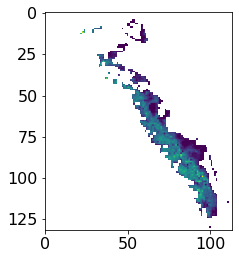

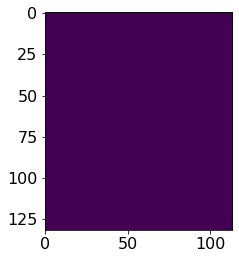

In [64]:
# export
gt = ds.GetGeoTransform()
proj = ds.GetProjection()

band = ds.GetRasterBand(1)
array = band.ReadAsArray()

plt.figure()
plt.imshow(array)

# manipulate
binmask = np.where((array <= np.mean(array)),1,0)
plt.figure()
plt.imshow(binmask)
driver = gdal.GetDriverByName("GTiff")
driver.Register()
outds = driver.Create("binmask.tif", xsize = binmask.shape[1],
                      ysize = binmask.shape[0], bands = 1, 
                      eType = gdal.GDT_Int16)
outds.SetGeoTransform(gt)
outds.SetProjection(proj)
outband = outds.GetRasterBand(1)
outband.WriteArray(binmask)
outband.SetNoDataValue(np.nan)
outband.FlushCache()

# close your datasets and bands!!!
outband = None
outds = None


In [55]:
len(swe_clipped.values.flatten()), len(clipped.values.flatten())

(7696398, 3180)

In [44]:
import gc
watershed_data_burned(targets=['Upper San Joaquin'],filename = 'sj_modis',gpp_opt = 'MODIS')

# watershed_data_burned(targets=targets_sw,filename = 'southwest_gosif',gpp_opt = 'GOSIF')
# watershed_data_burned(targets=targets_se,filename = 'southeast_gosif',gpp_opt = 'GOSIF')
# watershed_data_burned(targets=targets_ne,filename = 'northeast_gosif',gpp_opt = 'GOSIF')
# watershed_data_burned(targets=targets_nw,filename = 'northwest_gosif',gpp_opt = 'GOSIF')
'''
watershed_data_burned(targets=targets_sw,filename = 'southwest_modis',gpp_opt = 'MODIS')
watershed_data_burned(targets=targets_se,filename = 'southeast_modis',gpp_opt = 'MODIS')
watershed_data_burned(targets=targets_ne,filename = 'northeast_modis',gpp_opt = 'MODIS')
watershed_data_burned(targets=targets_nw,filename = 'northwest_modis',gpp_opt = 'MDOIS')
'''

128.60511363636363
185.3806818181818
154.29261363636363
469.5113636363636
590.5170454545455
539.0227272727273
585.9659090909091
433.96875
457.8238636363636
355.06534090909093
171.54261363636363
186.48863636363637
123.17613636363636
106.82670454545455
261.6931818181818
354.44602272727275
572.1363636363636
575.5340909090909
550.5482954545455
426.88920454545456
437.92329545454544
344.17045454545456
249.5880681818182
91.49147727272727
93.34375
190.7784090909091
221.77272727272728
379.4744318181818
546.7840909090909
519.1193181818181
380.1818181818182
378.8181818181818
354.8806818181818
276.86647727272725
258.07102272727275
125.03125
175.3409090909091
145.11363636363637
316.6676136363636
332.1136363636364
463.62215909090907
509.5198863636364
280.7130681818182
478.58522727272725
402.61079545454544
352.46875
158.39204545454547
107.5965909090909
105.07102272727273
129.7244318181818
355.1448863636364
454.5198863636364
632.7585227272727
553.6789772727273
500.8636363636364
457.65909090909093
415.

"\nwatershed_data_burned(targets=targets_sw,filename = 'southwest_modis',gpp_opt = 'MODIS')\nwatershed_data_burned(targets=targets_se,filename = 'southeast_modis',gpp_opt = 'MODIS')\nwatershed_data_burned(targets=targets_ne,filename = 'northeast_modis',gpp_opt = 'MODIS')\nwatershed_data_burned(targets=targets_nw,filename = 'northwest_modis',gpp_opt = 'MDOIS')\n"

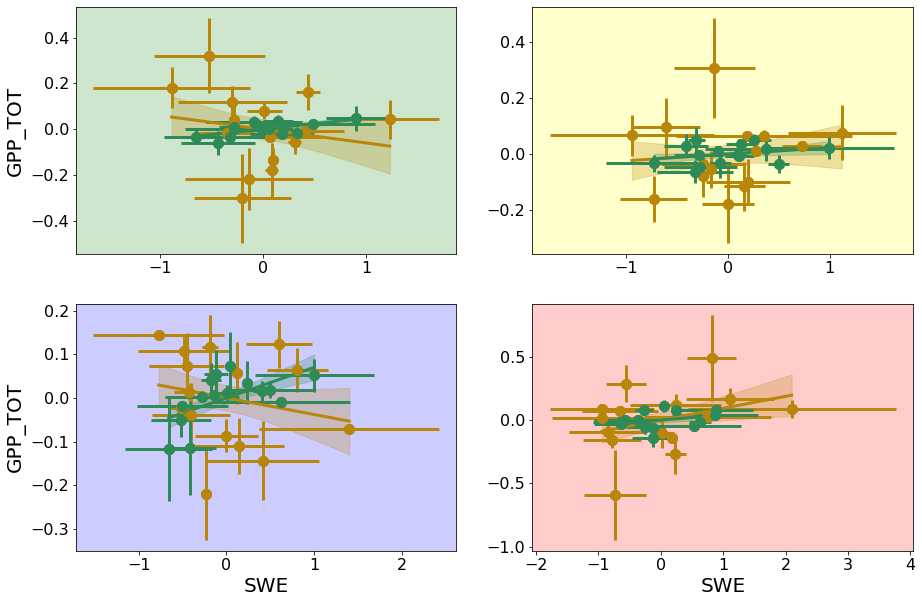

In [13]:
# plot_linear_four(xvar = 'swe',yvar = 'ndvi')
plot_linear_four(xvar = 'swe',yvar = 'gpp_tot', gpp_opt='GOSIF',normal=True)
# plot_linear_four(xvar = 'swe',yvar = 'gpp_tot',gpp_opt = 'MODIS')


#plot_linear(region = 'southeast',xvar = 'swe',yvar = 'gpp_tot')
#plot_linear(region = 'northeast',xvar = 'swe',yvar = 'gpp_tot')
#plot_linear(region = 'southwest',xvar = 'swe',yvar = 'gpp_tot')

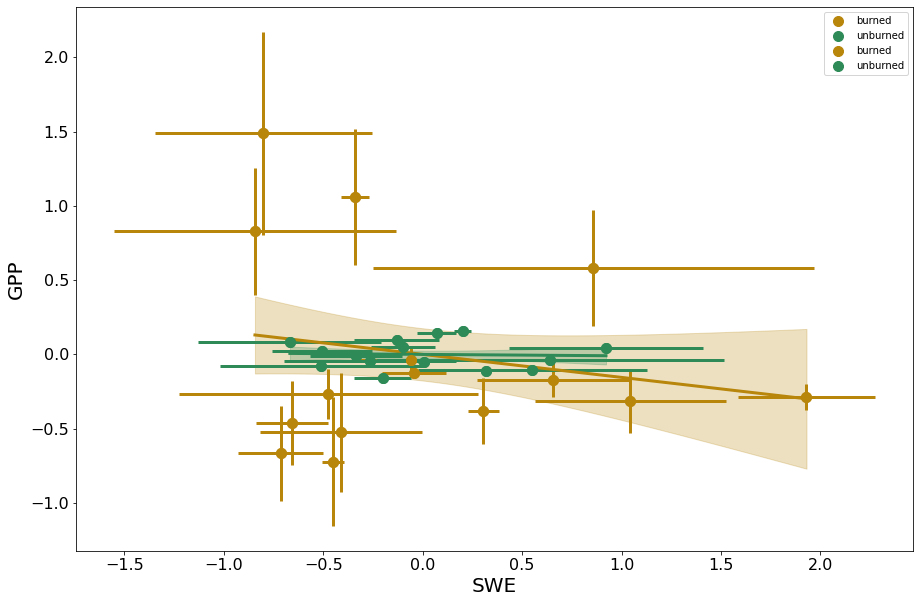

In [12]:
normal = True
xvar = 'swe'
yvar = 'gpp'
gpp_opt = 'GOSIF'
f,ax=plt.subplots(1,1,figsize=(15,10))
col_b = 'darkgoldenrod'
col_u ='seagreen'
region = 'sj'
with open(pe_data_dir + region + '_'+ gpp_opt + '.pkl', 'rb') as file:
    data = pickle.load(file)

if normal:
    x_b = normalize(data[xvar+'_means_burned'])
    y_b = normalize(data[yvar+'_means_burned'])
    x_u = normalize(data[xvar+'_means_unburned'])
    y_u = normalize(data[yvar+'_means_unburned'])
    y_b_err = normalize(data[yvar+'_dev_burned'])
    x_b_err = normalize(data[xvar+'_dev_burned'])
    y_u_err = normalize(data[yvar+'_dev_unburned'])
    x_u_err = normalize(data[xvar+'_dev_unburned'])
else:
    x_b = data[xvar+'_means_burned']
    y_b = data[yvar+'_means_burned']
    x_u = data[xvar+'_means_unburned']
    y_u = data[yvar+'_means_unburned']
    y_b_err = data[yvar+'_dev_burned']
    x_b_err = data[xvar+'_dev_burned']
    y_u_err = data[yvar+'_dev_unburned']
    x_u_err = data[xvar+'_dev_unburned']

n = 1  # degree of polynomial

p_b, C_p_b = np.polyfit(x_b, y_b, n, cov=True)  # C_p is estimated covariance matrix
t_b = np.linspace(min(x_b), max(x_b), 500)
TT_b = np.vstack([t_b**(n-i) for i in range(n+1)]).T
yi_b = np.dot(TT_b, p_b)  # matrix multiplication calculates the polynomial values
C_yi_b = np.dot(TT_b, np.dot(C_p_b, TT_b.T)) # C_y = TT*C_z*TT.T
sig_yi_b = np.sqrt(np.diag(C_yi_b))  # Standard deviations are sqrt of diagonal

p_u, C_p_u = np.polyfit(x_u, y_u, n, cov=True)  # C_p is estimated covariance matrix
t_u = np.linspace(min(x_u), max(x_u), 500)
TT_u = np.vstack([t_u**(n-i) for i in range(n+1)]).T
yi_u = np.dot(TT_u, p_u)  # matrix multiplication calculates the polynomial values
C_yi_u = np.dot(TT_u, np.dot(C_p_u, TT_u.T)) # C_y = TT*C_z*TT.T
sig_yi_u = np.sqrt(np.diag(C_yi_u))  # Standard deviations are sqrt of diagonal


ax.plot(x_b,y_b,'o',color=col_b,label='burned')
ax.errorbar(x_b,y_b,yerr = y_b_err,xerr=x_b_err,fmt = 'o',color=col_b,label='burned')
ax.fill_between(t_b, yi_b+sig_yi_b, yi_b-sig_yi_b, alpha=.25,color=col_b)
ax.plot(t_b, yi_b,'-',color=col_b)


ax.plot(x_u,y_u,'o',color=col_u,label='unburned')
ax.errorbar(x_u,y_u,yerr = y_u_err,xerr=x_u_err,fmt = 'o',color=col_u,label='unburned')

ax.fill_between(t_u, yi_u+sig_yi_u, yi_u-sig_yi_u, alpha=.25,color=col_u)
ax.plot(t_u, yi_u,'-',color=col_u)

ax.patch.set_alpha(0.2)

# ax.patch.set_facecolor(colors[k]) #,alpha=0.5)


slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_b, y_b)
slope_u, intercept_u, r_value_u, p_value_u, std_err_u = stats.linregress(x_u, y_u)

ax.set_xlabel(xvar.upper())
ax.set_ylabel(yvar.upper())
# axs[k].set_title(region)
ax.legend()
plt.show()

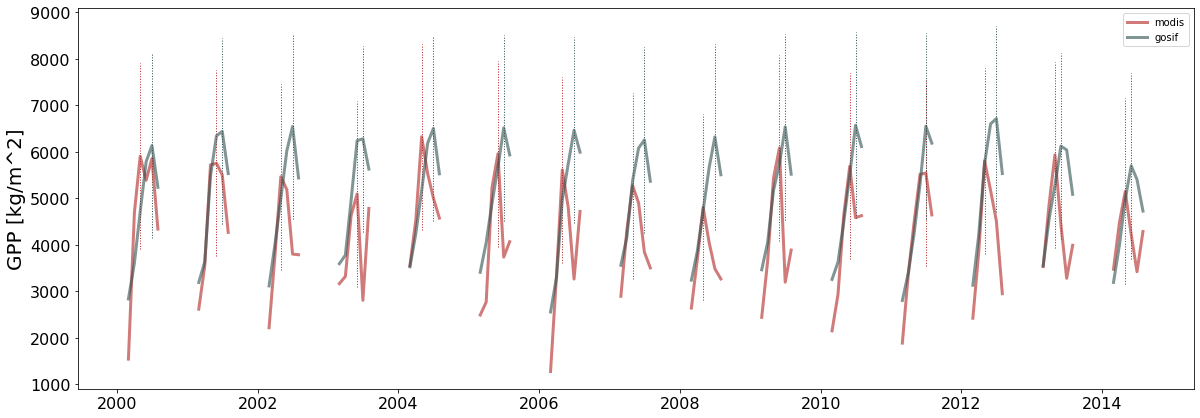

In [158]:
alpha = 0.6
fn = 'sj_modis'
with open(pe_data_dir + fn + '.pkl', 'rb') as file:
            data2 = pickle.load(file)

gpp_by_month_burned = data2['gpp_by_month_burned']
gpp_by_month_unburned = data2['gpp_by_month_unburned']
gpp_by_month = data2['gpp_by_month']

months = range(3,9)
texts = ['March', 'April','May','June','July','August','September']
midx = [m-1 for m in months]


handles,labels = [],[]
f,ax=plt.subplots(figsize=(20,7))
'''for yr in range(2000,2015):
    data= gpp_by_month_unburned[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'k-')
    ax.scatter(dates,data,c=range(6), cmap='BrBG',s=130, zorder=2.5)'''

'''for yr in range(2000,2015):
    data= gpp_by_month_burned[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'k-')
    ax.scatter(dates,data,c=range(6), cmap='Reds',s=130, zorder=2.5)'''

for yr in range(2000,2015):
    data= gpp_by_month[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    data = data*10
    ax.plot(dates,data,'-',color='firebrick',alpha = alpha,label = 'modis')
    idx = np.nanargmax(data)
    ax.vlines(dates[idx],data[idx]-2000,data[idx]+2000,color = 'firebrick',linewidth=1,linestyle=':')
    #ax.scatter(dates,data,c=range(len(dates)), cmap='BrBG',s=130, zorder=2.5)
# ax.plot(dates,data*10,'-',color='k',alpha = 1,label = 'modis')

yr = 2006
dates = [datetime.datetime(yr+m,m,1) for m in months]
n=1.4 * np.nanmax(data)
ydot = [n for i in range(len(dates))]
#ax.plot(dates,ydot,'k-')
#ax.scatter(dates,ydot,c=range(len(dates)), cmap='BrBG',s=130, zorder=2.5)
#for i in range(len(midx)):
#    ax.text(dates[i]+datetime.timedelta(days=-90),ydot[i]-250,texts[i],size=12)

fn = 'sj_gosif'
with open(pe_data_dir + fn + '.pkl', 'rb') as file:
            data2 = pickle.load(file)

gpp_by_month_burned = data2['gpp_by_month_burned']
gpp_by_month_unburned = data2['gpp_by_month_unburned']
gpp_by_month = data2['gpp_by_month']
for yr in range(2000,2015):
    data= gpp_by_month[yr-2000,midx]
    dates = [datetime.datetime(yr,m,1) for m in months]
    ax.plot(dates,data,'-',color='darkslategray',alpha = alpha,label = 'gosif')
    idx = np.nanargmax(data)
    ax.vlines(dates[idx],data[idx]-2000,data[idx]+2000,color = 'darkslategray',linewidth=1,linestyle=':')
handles,labels = ax.get_legend_handles_labels()

# ax.plot(dates,data,'-',color='firebrick',alpha = 1,label = 'gosif')
ax.legend(handles = [handles[1],handles[-1]],labels = [labels[1],labels[-1]])
ax.set_ylabel('GPP [kg/m^2]')
plt.show()


In [164]:
tmp = np.load(pe_data_dir + 'data1993.npy',allow_pickle= True)

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [26]:
data_sw['gpp_by_month_burned']

array([[ 0.        ,  0.        , 10.40380117, ...,  0.        ,
         0.        ,  0.        ],
       [37.49473684, 31.83625731,  9.71871345, ...,  0.        ,
         0.        ,  0.        ],
       [15.51578947, 13.57192982,  8.50438596, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

-0.2935137256361064 0.5089805076787988 0.002822426299266138


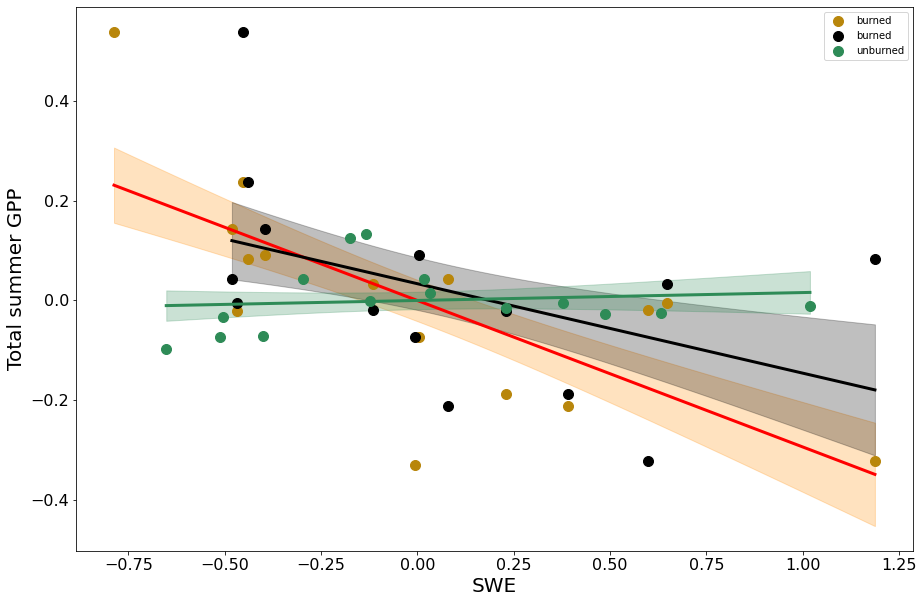

In [280]:
f,ax=plt.subplots(figsize=(15,10))
x = normalize(swe_means_burned)
y = normalize(ndvi_means_burned)
y2 = [y[i+1] for i in range(len(y)-1)]
idx=np.nanargmax(y)
x2 = x[0:-1]
#x = np.delete(x,idx)
#y = np.delete(y,idx)
#x = swe_means_burned
#y = gpp_means_burned
ax.plot(x,y,'o',color='darkgoldenrod',label='burned')

ax.plot(x2,y2,'o',color='black',label='burned, plus one year')
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
#ax.plot(x,p(x),"r--")

n = 1  # degree of polynomial
p, C_p = np.polyfit(x, y, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x), max(x), 500)
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='darkorange')
ax.plot(t, yi,'-',color='red')

z = np.polyfit(x2, y2, 1)
p = np.poly1d(z)
#ax.plot(x,p(x),"r--")

n = 1  # degree of polynomial
p, C_p = np.polyfit(x2, y2, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x2), max(x2), 500)
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='black')
ax.plot(t, yi,'-',color='black')
#ax.axis('tight')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(slope, r_value**2,p_value)

x = normalize(swe_means_unburned)
y = normalize(ndvi_means_unburned)
ax.plot(x,y,'o',color='seagreen',label='unburned')
n = 1  # degree of polynomial
p, C_p = np.polyfit(x, y, n, cov=True)  # C_p is estimated covariance matrix

# Do the interpolation for plotting:
t = np.linspace(min(x), max(x), 500)
TT = np.vstack([t**(n-i) for i in range(n+1)]).T
yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

ax.fill_between(t, yi+sig_yi, yi-sig_yi, alpha=.25,color='seagreen')
ax.plot(t, yi,'-',color='seagreen')
#ax.axis('tight')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)


#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)
#ax.plot(x,p(x),":",color='seagreen')
ax.set_xlabel('SWE')
ax.set_ylabel('Total summer GPP')
ax.legend()
plt.show()

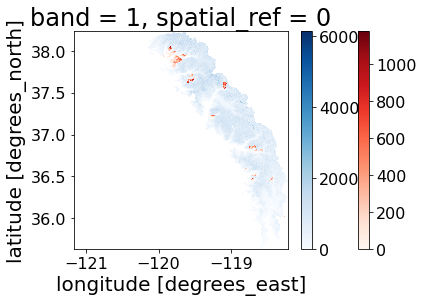

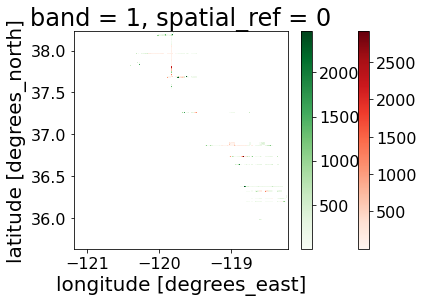

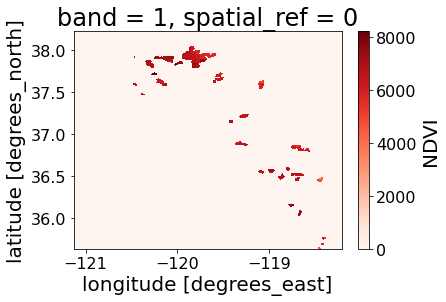

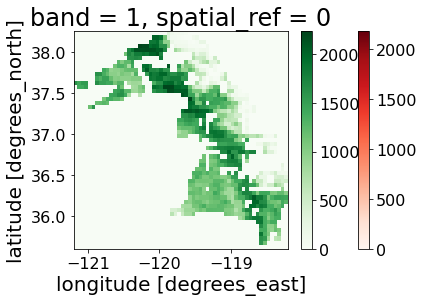

In [ ]:
k=2000
f,ax=plt.subplots()
swe_sj_burned[k].plot(ax=ax,cmap='Reds')
swe_sj_unburned[k].plot(ax=ax,cmap='Blues')
plt.show()
k=2015
f,ax=plt.subplots()
sai_sj_burned[k].plot(ax=ax,cmap='Reds')
sai_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()
k=2000
f,ax=plt.subplots()
ndvi_sj_burned[k].plot(ax=ax,cmap='Reds')
#ndvi_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()
k=2000
f,ax=plt.subplots()
gpp_sj_burned[k].plot(ax=ax,cmap='Reds')
gpp_sj_unburned[k].plot(ax=ax,cmap='Greens')
plt.show()


In [21]:
with open(pe_data_dir + 'southwest' + '.pkl', 'rb') as file:
            data_sw = pickle.load(file)

Text(0, 0.5, 'sum')

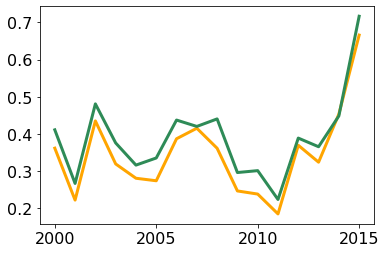

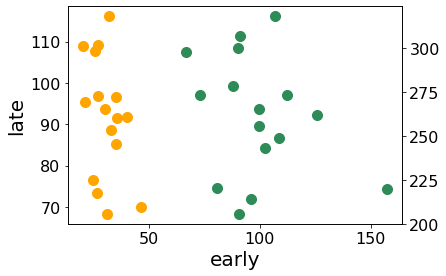

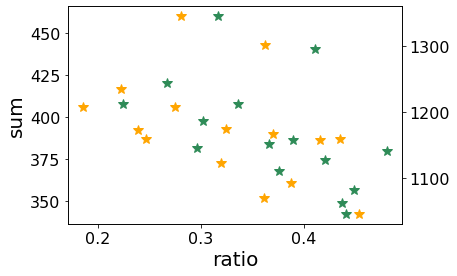

In [84]:
gpp_by_month_burned = data['gpp_by_month_burned']
gpp_by_month_unburned = data['gpp_by_month_unburned']
#gpp_by_month_burned = data['gpp_by_month_burned']
#gpp_by_month_burned = data['gpp_by_month_burned']


early_b = gpp_by_month_burned[0:16,1]
late_b = gpp_by_month_burned[0:16,5]
total_b = [np.nansum(gpp_by_month_burned[i,2:7]) for i in range(16)]
early_u = gpp_by_month_unburned[0:16,1]
late_u = gpp_by_month_unburned[0:16,5]
total_u = [np.nansum(gpp_by_month_unburned[i,2:7]) for i in range(16)]
years = range(2000,2016)
plt.plot(years, early_b/late_b,color ='orange')
plt.plot(years, early_u/late_u,color = 'seagreen')
f,ax = plt.subplots()
ax2=ax.twinx()
ax.plot(early_b,late_b,'o',color='orange')
ax2.plot(early_u,late_u,'o',color='seagreen')
ax.set_xlabel('early')
ax.set_ylabel('late')
f,ax=plt.subplots()
ax2=ax.twinx()
ax.plot(early_b[0:15]/late_b[0:15],total_b[0:15],'*',color='orange')
ax2.plot(early_u[0:15]/late_u[0:15],total_u[0:15],'*',color='seagreen')
ax.set_xlabel('ratio')
ax.set_ylabel('sum')

Text(0.33, 454, '$r^2$ = 0.295, $p$ =0.037')

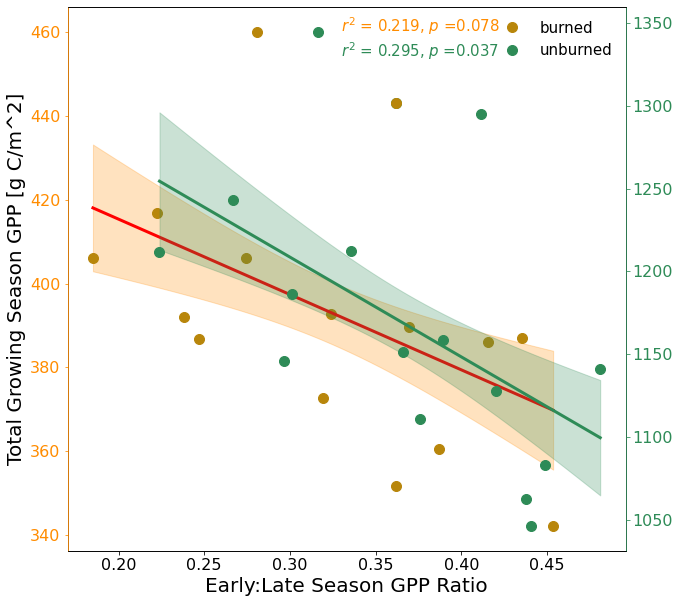

In [121]:
f,ax=plt.subplots(figsize=(10,10))
early_b = gpp_by_month_burned[0:16,1]
late_b = gpp_by_month_burned[0:16,5]
total_b = [np.nansum(gpp_by_month_burned[i,2:7]) for i in range(16)]
early_u = gpp_by_month_unburned[0:16,1]
late_u = gpp_by_month_unburned[0:16,5]
total_u = [np.nansum(gpp_by_month_unburned[i,2:7]) for i in range(16)]
#plt.plot(early_b/late_b)

x_b=early_b/late_b
x_b=x_b[0:15]
y_b = total_b[0:15]
x_u = early_u/late_u
x_u=x_u[0:15]
y_u=total_u[0:15]
n = 1  # degree of polynomial
        
p_b, C_p_b = np.polyfit(x_b, y_b, n, cov=True)  # C_p is estimated covariance matrix
t_b = np.linspace(min(x_b), max(x_b), 500)
TT_b = np.vstack([t_b**(n-i) for i in range(n+1)]).T
yi_b = np.dot(TT_b, p_b)  # matrix multiplication calculates the polynomial values
C_yi_b = np.dot(TT_b, np.dot(C_p_b, TT_b.T)) # C_y = TT*C_z*TT.T
sig_yi_b = np.sqrt(np.diag(C_yi_b))  # Standard deviations are sqrt of diagonal

p_u, C_p_u = np.polyfit(x_u, y_u, n, cov=True)  # C_p is estimated covariance matrix
t_u = np.linspace(min(x_u), max(x_u), 500)
TT_u = np.vstack([t_u**(n-i) for i in range(n+1)]).T
yi_u = np.dot(TT_u, p_u)  # matrix multiplication calculates the polynomial values
C_yi_u = np.dot(TT_u, np.dot(C_p_u, TT_u.T)) # C_y = TT*C_z*TT.T
sig_yi_u = np.sqrt(np.diag(C_yi_u))  # Standard deviations are sqrt of diagonal

ax2=ax.twinx()
ax.plot(x_b,y_b,'o',color='darkgoldenrod',label='burned')
ax.fill_between(t_b, yi_b+sig_yi_b, yi_b-sig_yi_b, alpha=.25,color='darkorange')
ax.plot(t_b, yi_b,'-',color='red')


ax2.plot(x_u,y_u,'o',color='seagreen',label='unburned')
ax2.fill_between(t_u, yi_u+sig_yi_u, yi_u-sig_yi_u, alpha=.25,color='seagreen')
ax2.plot(t_u, yi_u,'-',color='seagreen')


ax.set_xlabel('Early:Late Season GPP Ratio')
ax.set_ylabel('Total Growing Season GPP [g C/m^2]')
ax2.spines['left'].set_color('darkorange')
ax2.spines['right'].set_color('seagreen')
ax.tick_params(axis='y', colors='darkorange')
ax2.tick_params(axis='y', colors='seagreen')


ax.plot(x_b[0],y_b[0],'o',color='seagreen',label='unburned',zorder=0)
ax.legend(fontsize=15,frameon=False)

slope_u, intercept_u, r_value_u, p_value_u, std_err_u = stats.linregress(x_u, y_u)
slope_b, intercept_b, r_value_b, p_value_b, std_err_b = stats.linregress(x_b, y_b)

ax.text(0.33,460,r'$r^2$ = '+ str(round(r_value_b**2,3))+', $p$ =' + str(round(p_value_b,3)),color='darkorange',fontsize=15)
ax.text(0.33,454,r'$r^2$ = '+ str(round(r_value_u**2,3)) +', $p$ =' + str(round(p_value_u,3)),color='seagreen',fontsize=15)



In [88]:
print('r2 u:', r_value_u**2, 'r^2b',r_value_b**2)
print('p u:', p_value_u, 'p b',p_value_b)

r2 u: 0.29472950037302903 r^2b 0.21941345808296764
p u: 0.03650825240883211 p b 0.07822573917028484


array([25.23636364, 24.        , 19.67444254, 35.71766724, 22.01509434,
       26.62401372, 23.58216123, 26.38696398, 19.02915952, 34.79039451,
       25.75300172, 24.63430532, 32.59073756, 21.89502573, 33.74785592,
       39.24150943,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

0.3634056512118447